# Bias vs Variance

**练习通过绘制学习曲线（learning curve）来对模型的bias及variance进行判断**

* 实现一个普通的线性回归模型，评价该模型特性
* 通过特征映射的方式实现多项式回归模型，评价模型特性
* 通过规整方法实现模型调整
   * 通过交叉验证实现规整参数的最优选择

# 实现线性回归

In [162]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.optimize as opt 
import seaborn as sns

In [163]:
def load_data(path):
    data = sio.loadmat(path)
    return map(np.ravel,[data["X"],data["y"],data["Xval"],data["yval"],data["Xtest"],data["ytest"]])

In [164]:
X,y,Xval,yval,Xtest,ytest = load_data("ex5data1.mat")

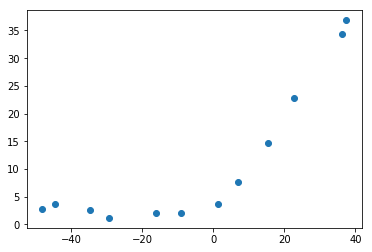

In [165]:
plt.scatter(X,y)
plt.show()

In [166]:
y.shape

(12,)

**添加1特征**

In [167]:
X,Xval,Xtest = [np.insert(x.reshape(x.shape[0],1),0,np.ones((x.shape[0])),axis=1)for x in (X,Xval,Xtest)]

**实现线性回归**

* 特别注意维度的吻合，为了使用opt.minimize只能讲theta定义为（12，）这种形式，这样的话y也需要这种形式与之吻合

In [168]:
def cost(theta,X,y):
    #inner = X@theta-y
    #square_sum = np.sum(np.power(inner,2))
    #cost = square_sum/(2*len(X))
    return (1/(2*len(X)))*np.sum(np.power(X@theta-y,2))
    #return cost

In [169]:
theta = np.ones(X.shape[1])
cost(theta,X,y)

303.9515255535976

In [170]:
def regularized_cost(theta,X,y,l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [175]:
theta = np.ones(X.shape[1])
regularized_cost(theta,X,y)

303.9931922202643

In [171]:
def gradient(theta,X,y):
    m = X.shape[0]
    inner = X.T@(X@theta-y)
    return inner/m

In [172]:
gradient(theta,X,y)

array([-15.30301567, 598.16741084])

In [173]:
def regularized_gradient(theta,X,y,l=1):
    m = X.shape[0]
    regu_thea = theta.copy()
    regu_thea[0] = 0
    regu_term = (l/m)*regu_thea
    return gradient(theta,X,y)+regu_term

In [174]:
regularized_gradient(theta,X,y)

array([-15.30301567, 598.25074417])

**拟合数据**
>正则化系数=0

In [176]:
def linear_regression_np(X,y,l=1):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X,y,l),
                       jac=regularized_gradient)
    return res 

In [177]:
theta = np.ones(X.shape[0])
final_thea = linear_regression_np(X,y,l=0).get('x')

0.3677792303199833 13.087903528670243


<function matplotlib.pyplot.show(*args, **kw)>

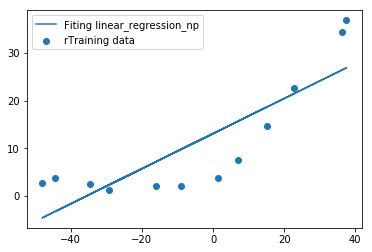

In [178]:
b = final_thea[0]
k = final_thea[1]
print(k,b)
plt.scatter(X[:,1],y,label="rTraining data")
plt.plot(X[:,1],X[:,1]*k+b,label="Fiting linear_regression_np")
plt.legend(loc=2)
plt.show

# 绘制学习曲线

**学习曲线表示训练样本数与训练误差、验证误差之间的关系**

1. 使用训练集的子集来对学习模型参数

2. 训练代价只在训练子集上计算，验证代价在整个验证集上计算，且不使用正则化

3. 最好每次随机的选择训练子集，但数量递增

In [179]:
training_cost,cv_cost = [],[]
m = X.shape[0]
for i in range(1,m+1):
    
    #rand_idx = np.random.choice(range(0,m-1,1),i)
    #Xi = X[rand_idx,:]
   # yi = y[rand_idx]
   # res = linear_regression_np(Xi,yi,l=0)
    
    #train_cost = regularized_cost(res.x,Xi,yi,l=0)
    #cvv_cost = regularized_cost(res.x,Xval,yval,l=0)
    
    res = linear_regression_np(X[:i, :], y[:i], l=0)  # 可以每次都随机的选取
    
    train_cost = regularized_cost(res.x, X[:i, :], y[:i], l=0)  # 在当前训练集上计算
    cvv_cost = regularized_cost(res.x, Xval, yval, l=0)     #都在CV集上计算
    
    training_cost.append(train_cost)
    cv_cost.append(cvv_cost)

In [180]:
print(cv_cost)

[169.87070848926905, 110.30036501858208, 45.01023137857432, 48.368911369819514, 35.86516475031185, 33.82996159714836, 31.970985950507306, 30.862446457324243, 31.13599798306163, 28.93620746663707, 29.551431344587225, 29.43381811952012]


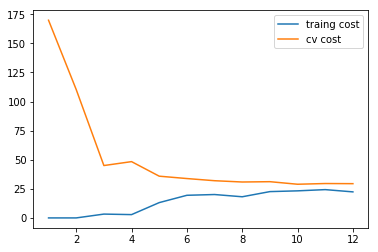

In [181]:
plt.plot(np.arange(1,m+1),training_cost,label="traing cost")
plt.plot(np.arange(1,m+1),cv_cost,label="cv cost")
plt.legend(loc=1)
plt.show()

**从上面结果可以看出，无论训练代价还是验证代价都比较高**

这个模型拟合不太好, **欠拟合了**  随训练样本的增加，训练误差还在上升，说明没有能够很好的拟合

* 添加特征

# 创建多项式特征
>x->( x x^2 x^3 ...)

1. 扩展特征
2. 对特征进行归一化
3. 添加截距项1

In [182]:
def ploy_features(x,power,as_ndarrary = False):
    data = {"f{}".format(i):np.power(x,i) for i in range(1,power+1)}
    df = pd.DataFrame(data)
    return df.as_matrix() if as_ndarrary else df

In [183]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [184]:
def prepare_poly_data(*args,power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        df = ploy_features(x,power=power)
        #nomalization
        ndarr = normalize_feature(df).as_matrix()
        return np.insert(ndarr,0,np.ones(ndarr.shape[0]),axis=1)
    return [prepare(x)for x in args]

In [185]:
X, y, Xval, yval, Xtest, ytest = load_data("ex5data1.mat")
ploy_features(X,power =3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [186]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 拟合模型 画出学习曲线

> 首先不使用正则化

In [187]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = regularized_cost(res.x, X[:i, :], y[:i],l=0)
        cv = regularized_cost(res.x, Xval, yval,l=0)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


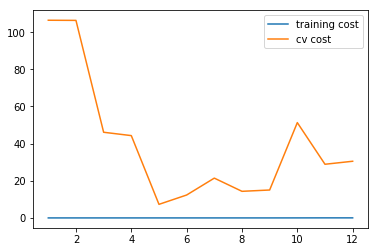

In [188]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了  **关键是CV误差没有降下来**

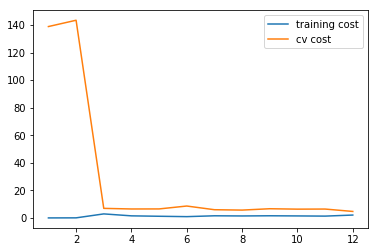

In [189]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

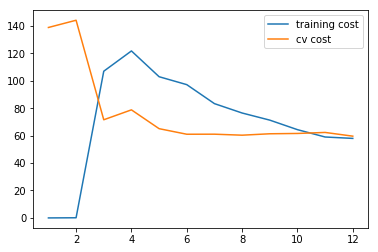

In [190]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

# 寻找最佳正则化系数

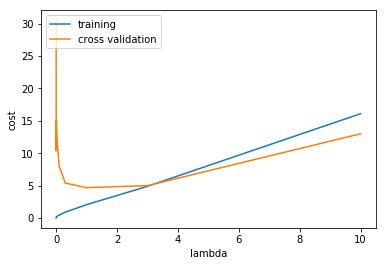

In [191]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [193]:
print(cv_cost)
print(np.argmin(cv_cost))  # 返回最小位置
l_candidate[np.argmin(cv_cost)]

[30.506606761074163, 10.368371546185989, 14.810726652459293, 15.074044387801727, 12.040889880254127, 7.999290377626388, 5.396697445355364, 4.696681661956069, 5.005838683843396, 13.003203095154452]
7


1

**测试不同参数下测试数据的表现**

In [195]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(Xtest_poly, ytest, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 1.3522418306252577
test cost(l=0.001) = 1.3553455453857475
test cost(l=0.003) = 1.3603892131529691
test cost(l=0.01) = 1.3830017705300577
test cost(l=0.03) = 1.4614327760314825
test cost(l=0.1) = 1.6273514446258202
test cost(l=0.3) = 1.7705389936589278
test cost(l=1) = 1.9882372080719894
test cost(l=3) = 3.0648768511471873
test cost(l=10) = 10.12893599588956


**可以看出，CV集合获取的最小参数在TEST集合下可能会有所不一致**